In [84]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler



chemin = "C:/Users/lucas/Desktop/deep_learning_prediction_conso_electrique/DATA/"
numeric_columns = ['elec_MW', 'mois', 'jour_sem','temp_moy_K','pmer_moy_Pa']
scaled_cols = ['elec_MW','temp_moy_K','pmer_moy_Pa']

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

#Hyperparamètres
lookback = 30
batch_size = 64
num_epochs = 60
learning_rate = 0.001
# Définir les paramètres du modèle
input_size = len(numeric_columns)  # La taille d'entrée, qui est 5 car nous avons 5 variables temporelles
hidden_size = 64 # La taille du vecteur caché dans la couche GRU
num_layers = 1  # Le nombre de couches GRU
output_size = 1  # La taille de la sortie, qui est 1 car nous prédisons une seule valeur
n_days = 20

data = pd.read_csv(chemin+"train_test_jours_variables.csv")
data['jour_sem'] = np.cos(data["jour_sem"]*(2*np.pi)/7) #on encode les jours avec un cosinus pour retranscrire la periodicité
data['mois'] = np.cos(data["mois"]*(2*np.pi)/12) #on encode les mois avec un cosinus pour retranscrire la periodicité
serie_train = data[data['type'] == 'TRAIN']
serie_test = data[data['type'] == 'TEST']
serie_train = serie_train[numeric_columns]
serie_test = serie_test[numeric_columns]
mu=np.mean(serie_train["elec_MW"])
sd = np.sqrt(np.var(serie_train["elec_MW"]))
scaler = StandardScaler()
serie_train[scaled_cols]=scaler.fit_transform(serie_train[scaled_cols])
serie_test[scaled_cols]=scaler.transform(serie_test[scaled_cols])
serie_val = serie_train[:int(0.2*len(serie_train))]
serie_train = serie_train[int(0.2*len(serie_train)):]

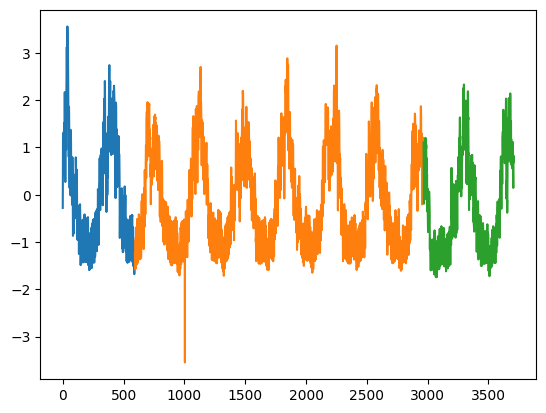

In [85]:
serie_train = torch.tensor(serie_train.values, dtype=torch.float32)
serie_val = torch.tensor(serie_val.values, dtype=torch.float32)
serie_test = torch.tensor(serie_test.values, dtype=torch.float32)

plt.plot(list(range(0,len(serie_val[:,0]))),serie_val[:,0])
plt.plot(list(range(len(serie_val[:,0]),len(serie_val[:,0])+len(serie_train[:,0]))),serie_train[:,0])
plt.plot(list(range(len(serie_val[:,0])+len(serie_train[:,0]),len(serie_val[:,0])+len(serie_train[:,0])+len(serie_test[:,0]))),serie_test[:,0])

In [86]:
class TimeSeriesDataset(Dataset):
    def __init__(self, time_series, lookback):
        self.time_series = time_series 
        self.lookback = lookback

    def __len__(self):
        return len(self.time_series) - self.lookback

    def __getitem__(self, idx):
        x = self.time_series[idx:idx + self.lookback,:]
        y = self.time_series[idx + self.lookback,0]
        return x, y

train_dataset = TimeSeriesDataset(serie_train, lookback)
val_dataset = TimeSeriesDataset(serie_val, lookback)
test_dataset = TimeSeriesDataset(serie_test, lookback)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [87]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:,-1,:])  
        return out

model = GRUModel(input_size, hidden_size, num_layers, output_size)


In [88]:
def train_loop(dataloader, model, loss_fn, optimizer, device):

    model.train()

    for X, y in dataloader:
        # Reset gradients
        optimizer.zero_grad()
        # Forward
        pred = model(X.to(device))
        loss = loss_fn(pred, y.view(-1, 1).to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()


def eval_loop(dataloader, model, loss_fn, device):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0.

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            loss += loss_fn(pred, y.view(-1, 1).to(device)).item()

    loss /= num_batches
    return loss

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for t in range(num_epochs):
    print(f"Epoch {t + 1}\n-------------------------------------------------")

    # Train loop
    train_loop(train_dataloader, model, loss_fn, optimizer, device)

    # Evaluation loop
    loss_train = eval_loop(train_dataloader, model, loss_fn, device)
    print(f"Training set: Avg loss: {loss_train: >8f}")
    
    loss_test = eval_loop(val_dataloader, model, loss_fn, device)
    print(f"Val set: Avg loss: {loss_test: >8f}\n")

print("Done!")

Epoch 1
-------------------------------------------------
Training set: Avg loss: 0.153384
Val set: Avg loss: 0.207472

Epoch 2
-------------------------------------------------
Training set: Avg loss: 0.119227
Val set: Avg loss: 0.158020

Epoch 3
-------------------------------------------------
Training set: Avg loss: 0.092466
Val set: Avg loss: 0.119070

Epoch 4
-------------------------------------------------
Training set: Avg loss: 0.077985
Val set: Avg loss: 0.098039

Epoch 5
-------------------------------------------------
Training set: Avg loss: 0.074742
Val set: Avg loss: 0.095166

Epoch 6
-------------------------------------------------
Training set: Avg loss: 0.068233
Val set: Avg loss: 0.086070

Epoch 7
-------------------------------------------------
Training set: Avg loss: 0.063680
Val set: Avg loss: 0.079535

Epoch 8
-------------------------------------------------
Training set: Avg loss: 0.056728
Val set: Avg loss: 0.071844

Epoch 9
--------------------------------

In [89]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
tenseur = serie_train
X = tenseur[tenseur.size()[0]-lookback:,:]
Y = serie_test.clone()
y_preds = []
model.eval()
with torch.no_grad():
    for i in range(serie_test.size()[0]):
        ypred = model(X.unsqueeze(0))
        y_preds.append(float(ypred[0,0]))
        ycat = Y[i,:]
        ycat[0] = y_preds[-1]
        X = torch.cat((X[1:,:], ycat.unsqueeze(0)), dim=0)

In [90]:
y_preds = list(y_preds[:])
y_test = list(serie_test[:,0])
rmse=np.sqrt(np.mean((np.array(y_preds)-np.array(y_test))**2))
rmse2=np.sqrt(np.mean((np.array(y_preds[:n_days])-np.array(y_test[:n_days]))**2))
y_preds=[y*sd + mu for y in y_preds]
y_test=[y*sd + mu for y in y_test]

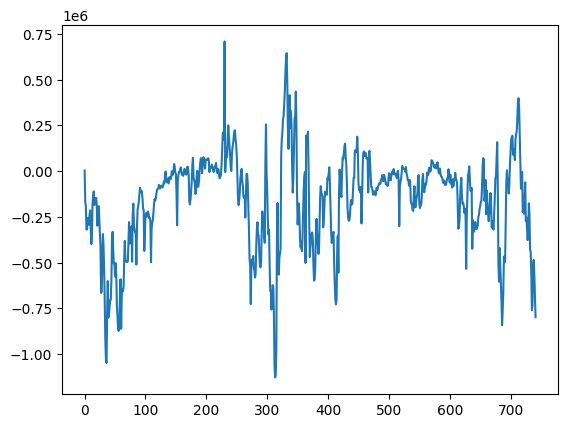

In [91]:
residuals = (np.array(y_test) - np.array(y_preds))
plt.plot(residuals)

In [92]:
qinf=np.percentile(residuals, 2.5)
qsup=np.percentile(residuals, 97.5)
print(f"Rmse : {rmse}")
print(f"qinf : {qinf}")
print(f"qsup : {qsup}")

Rmse : 0.5693799216106467
qinf : -763153.9209614665
qsup : 258786.75680046369


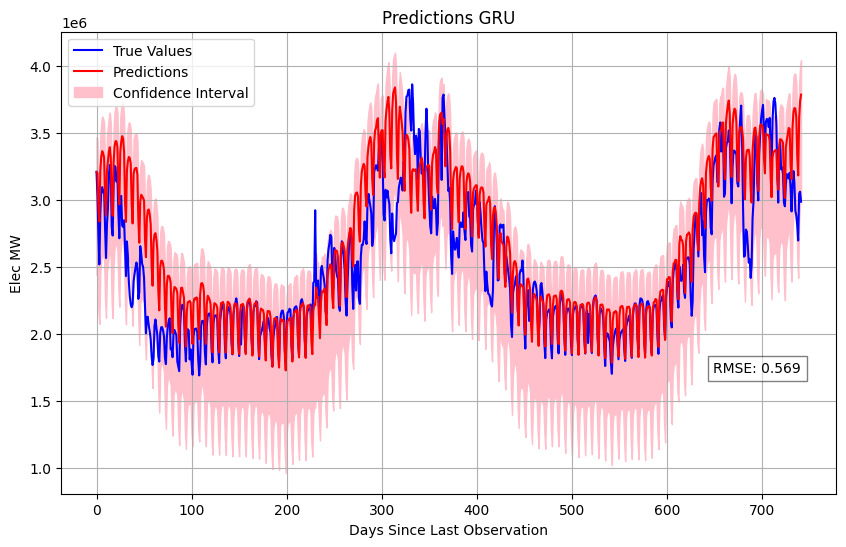

In [93]:
lower_bound = y_preds + qinf
upper_bound = y_preds + qsup

# Create the plot
plt.figure(figsize=(10, 6))

# Plot true values
plt.plot(range(len(y_test)), y_test, color='blue', label='True Values')

# Plot predictions
plt.plot(range(len(y_preds)), y_preds, color='red', label='Predictions')

# Plot confidence interval
plt.fill_between(range(len(y_preds)), lower_bound, upper_bound, color='pink', alpha=1, label='Confidence Interval')

# Customize the plot
plt.title('Predictions GRU')
plt.xlabel('Days Since Last Observation')
plt.ylabel('Elec MW')
plt.legend()
plt.grid(True)

# Add RMSE to the bottom right
plt.text(len(y_preds) - 1, min(y_test), f'RMSE: {rmse:.3f}', ha='right', va='bottom', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

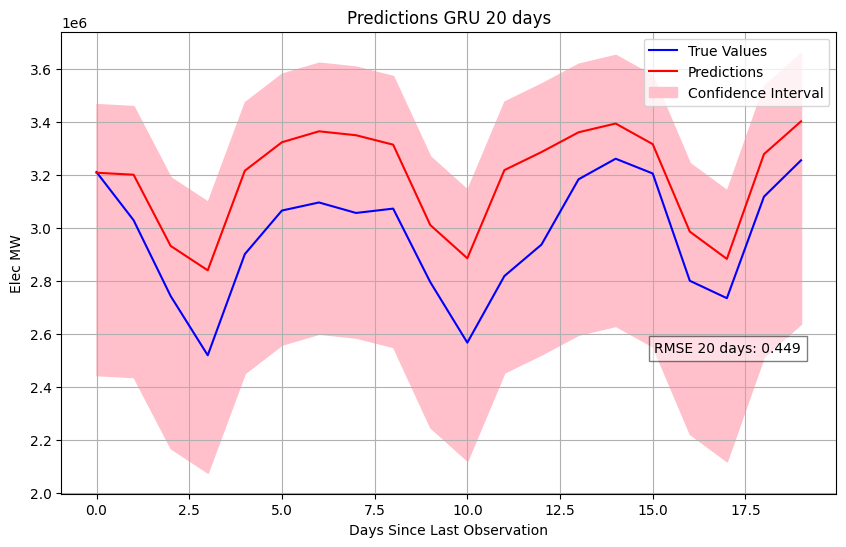

In [94]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot true values
plt.plot(range(len(y_test[:n_days])), y_test[:n_days], color='blue', label='True Values')

# Plot predictions
plt.plot(range(len(y_preds[:n_days])), y_preds[:n_days], color='red', label='Predictions')

# Plot confidence interval
plt.fill_between(range(len(y_preds[:n_days])), lower_bound[:n_days], upper_bound[:n_days], color='pink', alpha=1, label='Confidence Interval')

# Customize the plot
plt.title('Predictions GRU 20 days')
plt.xlabel('Days Since Last Observation')
plt.ylabel('Elec MW')
plt.legend()
plt.grid(True)

# Add RMSE to the bottom right
plt.text(len(y_preds[:n_days]) - 1, min(y_test[:n_days]), f'RMSE {n_days} days: {rmse2:.3f}', ha='right', va='bottom', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()